In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from scipy.io import loadmat
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import lsq_linear

import seaborn as sns
from sklearn import linear_model
import os
import time

from scipy.linalg import solve_discrete_lyapunov, solve_continuous_lyapunov

import json

import operator
import regex as re
from scipy.linalg import expm
#from numpy.linalg import matrix_rank
from networkx.algorithms import bipartite
from networkx.algorithms import components
import random
from scipy.spatial import distance


from scipy.linalg import svd

import nilearn as nilearn

In [13]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

def get_graph_from_adjacency(adjacency):        
    nodes_list = []
    for i in range( adjacency.shape[0] ):
        #node attribute is given by its neuron name
        nodes_list.append((i+1)) #,{"name":neuron_names[i]}))
    #print(len(nodes_list))

    # creating an edge list from adjacency matrix
    edge_list=[]
    for i in range( adjacency.shape[0] ) :
        for j in range(adjacency.shape[0]):
            if adjacency[i,j]==0: # if there's no weight, let's forget the edge.
                pass
            else:
                edge_list.append( (i+1,j+1,{"weight":adjacency[i,j]}) )
    # Creating a directed graph from adjacency matrix so that it will be easy to deal using the networkx module

    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    return G


def compute_B(N, unmatched_nodes):
    M = len(unmatched_nodes)
    if M==0:
        B = np.ones(N).astype(int)[:,np.newaxis]
        
    else:
        B = np.zeros((N,M))

        for i,j in zip(unmatched_nodes, range(B.shape[1])):
            B[i-1][j] = 1
    return B

def compute_C(N, target_nodes_list): # target matrix
    return compute_B(N, target_nodes_list).T
    

def controllability_matrix(A, B):
    C = deepcopy(B)
    temp = deepcopy(B)
    
    N = A.shape[0]
    for j in range(N-1):
        temp = np.matmul(A,temp)
        C = np.c_[C, temp] # same as hstack, append them side by side
        #print("C shape",C.shape)   
    return C


# [CB, CAB, CA^2B, ..., CA^(N-1)B ]
def target_controllability_matrix(A, B, C):
    d = np.matmul(C,B)#deepcopy(B)
    
    N = A.shape[0]
    for j in range(1,N):
        temp = np.matmul(C, np.matmul(np.linalg.matrix_power(A,j), B) )
        d = np.c_[d, temp] # same as hstack, append them side by side
        #print("C shape",C.shape)   
    return d




In [48]:
fpath = "./SUBJ_LEMON_02/"
mat_files = [f for f in sorted_alphanumeric(os.listdir(fpath)) if f.endswith('.mat') 
         and os.path.isfile(os.path.join(fpath, f))]



In [15]:
# nodes classified by their target regions/ subclusters of whole brain network

df_region = pd.read_csv(fpath+"regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()
regions = df_region[2].tolist()
region_dict = dict(zip(nodes, regions) )
region_dict

{1: 'Vis',
 2: 'Vis',
 3: 'SomMot',
 4: 'SomMot',
 5: 'SomMot',
 6: 'DorsAttn',
 7: 'DorsAttn',
 8: 'DorsAttn',
 9: 'DorsAttn',
 10: 'SalVentAttn',
 11: 'SalVentAttn',
 12: 'SalVentAttn',
 13: 'SalVentAttn',
 14: 'SalVentAttn',
 15: 'SalVentAttn',
 16: 'SalVentAttn',
 17: 'Limbic',
 18: 'Limbic',
 19: 'Limbic',
 20: 'Cont',
 21: 'Cont',
 22: 'Cont',
 23: 'Cont',
 24: 'Default',
 25: 'Default',
 26: 'Default',
 27: 'Default',
 28: 'Default',
 29: 'Default',
 30: 'Default',
 31: 'Default',
 32: 'Default',
 33: 'Vis',
 34: 'Vis',
 35: 'Vis',
 36: 'SomMot',
 37: 'SomMot',
 38: 'SomMot',
 39: 'DorsAttn',
 40: 'DorsAttn',
 41: 'DorsAttn',
 42: 'DorsAttn',
 43: 'DorsAttn',
 44: 'SalVentAttn',
 45: 'SalVentAttn',
 46: 'SalVentAttn',
 47: 'SalVentAttn',
 48: 'Limbic',
 49: 'Limbic',
 50: 'Cont',
 51: 'Cont',
 52: 'Cont',
 53: 'Cont',
 54: 'Cont',
 55: 'Cont',
 56: 'Default',
 57: 'Default',
 58: 'Default',
 59: 'Default',
 60: 'Default',
 61: 'Default',
 62: 'Default',
 63: 'Subcortical',
 64: 

In [16]:
region_list = list(np.unique(np.array(list(region_dict.values()))))

# target nodes associated with a given subcluster
def target_nodes(region_dict, region_name):
    targetNodes = []
    for node, region in region_dict.items():
        if region==region_name:
            targetNodes.append(node)
    return targetNodes



In [17]:

for i in range(len(region_list)):
    print(region_list[i])
    print(len(target_nodes(region_dict,region_list[i] )),"\n")

Cont
10 

Default
16 

DorsAttn
9 

Limbic
5 

SalVentAttn
11 

SomMot
6 

Subcortical
12 

Vis
5 



In [19]:
# Rank the nodes based on the following centrality measures

# References:
# Gustav Lindmark and Claudio Altafini. “Combining centrality measures for control energy reduction in network
# controllability problems”.

# Gustav Lindmark and Claudio Altafini. “Minimum energy control for complex networks”.


def rank_pq(A): #p_i by q_i, high to low
    N = len(A)
    
    centr_dict = {}
    for i in range(1,N+1):
        # either output node to be controlled for qi or input node to control i.e. pi
        e_i = compute_B(N, [i])
        
        # p_i
        W_i = solve_continuous_lyapunov(A, -np.matmul(e_i, e_i.T))
        p_i = np.trace(W_i)
        
        # q_i
        M_i = solve_continuous_lyapunov(A.T, -np.matmul(e_i, e_i.T))
        q_i = np.trace(M_i)
        
        centr_dict[i] = p_i/q_i
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=True)) # reverse = True -> h2l
    return sorted_d    
    
def rank_outDegree(A): # unweighted, low to high ranking 
    
    N = len(A)
    nodes = range(1,N+1)
    out_degree = np.sum(A!=0, axis=1).astype(int) # unweighted out-degree
    
    centr_dict = dict(zip(nodes, out_degree))
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=False)) # l2h
    
    return sorted_d
#rank_outDegree(A.T)
    
def rank_weight_OutbyIn_Degree(A): # weighted, high to low ranking 
    
    N = len(A)
    nodes = range(1,N+1)
    out_degree = np.sum(np.abs(A), axis=1) # weighted out-degree
    in_degree = np.sum(np.abs(A), axis=0) # weighted In-degree
    
    ratio = out_degree/in_degree
    
    
    centr_dict = dict(zip(nodes, ratio))
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=True)) # h2l
    
    return sorted_d

def rank_pageRank(A): # Unweighted, low to high
    #A = np.abs(A) # reason it doesn't converges is because of negative entries
    
    G = get_graph_from_adjacency(A)
    centr_dict = dict(nx.pagerank(G, alpha=0.85, tol=1e-06, max_iter=5000, weight="None"))#,weight='weight'))
    
    
    # unweighted page rank
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=False)) # l2h
    return sorted_d


In [20]:
import operator

def Nodes_energy_relation(adj_original, centrality, target_list, seed=123):
    A =  adj_original.T    # should be transpose according to Barabasi 2011 paper
    N = len(A)# N=74 in our case
    
    C = compute_C(N, target_list)# output target matrix
    
    if centrality=="random": # atleast 10 realizations has to be done.
        np.random.seed(seed)
        control_nodes = list(range(1,N+1))
        # randomize the control nodes
        np.random.shuffle(control_nodes)
        
    else:
        if centrality=="pq":
            sorted_d = rank_pq(A)
        elif centrality=="out_degree":
            sorted_d = rank_outDegree(A.T) # A should be orginal matrix
        elif centrality=="ratio_degree":
            sorted_d = rank_weight_OutbyIn_Degree(A.T)
        elif centrality=="page_rank":
            sorted_d = rank_pageRank(A.T)    
        
            
        control_nodes = list(sorted_d.keys())    
    
    Num_control_nodes = []
    min_evals_W = []
    
    while len(control_nodes)!=0:    
        Num_control_nodes.append(len(control_nodes))
        
        # compute B 
        # remember to sort the control nodes before constructing the input matrix B
        B = compute_B(N, sorted(control_nodes) )
        
        # check Kalman rank    
        d = target_controllability_matrix(A, B, C)
        rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
        if rank_d!=len(target_list):
            print("rank_d != S for Nd = ",B.shape[1])
            continue
            
        # compute W
        W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 
        
        W_c = np.matmul(C, np.matmul(W, C.T))
    
        # compute  e_min if possible
        min_evals_W.append( min(np.linalg.eigvals(W_c)) )
        
        # delete the control node which has lowest out degree.
        del control_nodes[-1]
    #print("Min eval:", min_evals_W)
    e_min_list = compute_e_min(min_evals_W)
        
    return (Num_control_nodes, e_min_list)

def compute_e_min(min_evals):
    # consider only real part of eigenvalues since there 
    # is numerically close to 0 for imaginary part
    min_evals = np.real(np.array(min_evals))
    
    # set all the eigen values less than 10^-12 as 10^-12 for plotting sake 
    min_evals[min_evals<1e-12]=1e-12
    
    e_min = np.array(min_evals)**-1
    return e_min


In [15]:
%%time

# Check whether the specified path exists or not
path = fpath+"target_controllability/"
isExist = os.path.exists(path)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)

############################################ only for random  ############################################

# results obtained after 10 randomizations
seed_list = list(range(100,110,1))

subject_names = [file[:-4] for file in mat_files]


for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
    isExist = os.path.exists(new_path)

    # if the folder doesn't exist, create a new folder
    if not isExist:
        os.makedirs(new_path)
        
    target_list = target_nodes(region_dict,region_name)

    
    for centrality in ["random"]:
        arr = []
        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"]
            sub_arr = []
            
            for seed in seed_list:
                Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality, \
                                                                 target_list=target_list, seed=seed)
                sub_arr.append(e_min)
                
            sub_arr = np.array(sub_arr )
            #print(mat_files[i])
            # mean is taken over 10 realizations of 74 regions of a given subject.
            arr.append(np.mean(sub_arr, axis=0 ) )
    
        # arr is of shape 23 x 74
        emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects

        # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
        df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
        df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)

        # save the dataframe
        df_23subj.to_csv(new_path+centrality+".csv", index=False)
        

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis
CPU times: user 4h 8min 9s, sys: 2h 16min 26s, total: 6h 24min 36s
Wall time: 1h 48min 28s


In [63]:
%%time
subject_names = [file[:-4] for file in mat_files]

path = fpath+"target_controllability/"

for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
    isExist = os.path.exists(new_path)

    # if the folder doesn't exist, create a new folder
    if not isExist:
        os.makedirs(new_path)
        
    target_list = target_nodes(region_dict,region_name)

    
    for centrality in ["page_rank","out_degree", "pq", "ratio_degree"]:
        arr = []
        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"]
            Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality, target_list=target_list)
            arr.append(e_min)

        # arr is of shape 23 x 74
        emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects

        # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
        df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
        df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)

        # save the dataframe
        df_23subj.to_csv(new_path+centrality+".csv", index=False)


    
        

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis
CPU times: user 1h 45min, sys: 59min 41s, total: 2h 44min 42s
Wall time: 45min 1s


In [23]:
# plotting the avg energy curves, averaged over 23 subjects, for different target regions

path = fpath+"target_controllability/"

for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
        
    target_list = target_nodes(region_dict,region_name)

    plt.figure(figsize=(8,5))

    for centrality in ["out_degree", "pq", "ratio_degree", "random", "page_rank"]:

        df = pd.read_csv(new_path+centrality+".csv")
        emin_avg = df.iloc[:,1:].mean(axis=1).tolist()
        Num_control_nodes = df.Num_control_nodes.tolist()
        plt.plot(Num_control_nodes, emin_avg,".-", label=centrality)

    plt.legend(loc="best", prop={"size":14})

    plt.tick_params(labelsize=14)
    plt.yscale("log")
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.8)

    plt.xlabel("No. of control inputs", size=15)
    plt.ylabel("Avg. min. energy", size=15)
    plt.title(region_name+" target controllability, target nodes = %d"%len(target_list), size=16)

    plt.savefig(new_path+region_name+"_target_controllability.png")
    plt.close()

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


# Wilcoxon test 
to compare the locations of two populations, in our case the curves of each centrality measure corresponding to 
a given subcluster. 

In [28]:
import scipy.stats as stats


In [54]:
# plotting the avg energy curves, averaged over 23 subjects, for different target regions
path = fpath+"target_controllability/"

for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
    
    row = []
    col = []
    ttest_val = []
    pval_list = []
    for centrA in ["out_degree", "pq", "ratio_degree", "page_rank", "random"]:
    #for centrA in ["pq"]:
    
        df = pd.read_csv(new_path+centrA+".csv")
        emin_centrA = np.log(df.iloc[:,1:].mean(axis=1).tolist())
        centr_list = ["out_degree", "pq", "ratio_degree", "page_rank", "random"]
        centr_list.remove(centrA)

        for centrB in centr_list:
            df = pd.read_csv(new_path+centrB+".csv")
            emin_centrB = np.log(df.iloc[:,1:].mean(axis=1).tolist())

            varA = np.var(emin_centrA)
            varB = np.var(emin_centrB)
            stat, pval = stats.wilcoxon(x=emin_centrB-emin_centrA, alternative="greater")
            if pval<0.005:
                # we have sufficient evidence to say that mean of 2 samples are different
                row.append(centrA)
                col.append(centrB)
                ttest_val.append(stat)
                pval_list.append(pval)
                
                
            else:
                # Because the p-value of our test is greater than alpha = 0.05, 
                # we fail to reject the null hypothesis of the test. We do not have 
                # sufficient evidence to say that the mean height of plants between the 
                # two populations is different.
                continue
    
    if len(row)!=0: #Only if there are values stored then plot heatmap
        key_list = list(zip(row, col))# list of lists [row, col]
        stat_dict = {}
        
        #print("Num rows == Num cols", set(row)==set(col))
        pval_list=-np.log(np.array(pval_list))
        count=0
        for key in key_list: 
            stat_dict[key]=pval_list[count]#ttest_val[count]
            count+=1
            
        uniq_centr = np.unique(row)    
        # plot heatmap for ttest where only p value < 0.05
        
        resultant = pd.DataFrame(data=[(0 for i in range(len(uniq_centr))) for i in range(len(uniq_centr))], 
                             columns=uniq_centr)
        resultant.set_index(pd.Index(uniq_centr), inplace = True)

        # Finding p_value for all columns and putting them in the resultant matrix
        for key in stat_dict.keys():
            #print(key[0],key[1])
            resultant.loc[key[0],key[1]] = stat_dict[key] 
        #print(resultant)

        fig = plt.figure(figsize=(7,4.5))
        sns.heatmap(resultant, annot=True, cmap='Blues', fmt=".3f")
        plt.title('Wilcoxon negative log p-value Results')
        plt.xticks(rotation=20,size=9)
        plt.yticks(rotation=20,size=9)
        plt.savefig(path+"%s_wilcoxTest.png"%region_name)
        plt.close()

    print("\n")
            
            

Cont


Default


DorsAttn


Limbic


SalVentAttn


SomMot


Subcortical


Vis




# Rank aggregation

We consider (let's say)top 10 nodes of a given centrality measure for all the 23 subjects. Then we apply rank aggregation to it, given us aggregated nodes based on that given centrality measure, and we use it as driver nodes.  

In [9]:
# Reference: https://github.com/djcunningham0/rankaggregation
import rankaggregation as ra



In [3]:
rank_list = [['A', 'B', 'C'], ['B', 'A', 'C'], ['C', 'D', 'A']]
agg = ra.RankAggregator()
agg.instant_runoff(rank_list)

['B', 'A', 'C', 'D']

In [4]:
agg.borda(rank_list)

[('A', 9), ('C', 8), ('B', 8.0), ('D', 5.0)]

In [34]:
type(agg.average_rank(rank_list))

list

In [8]:
def agg_rank(ranked_lists, agg_type, num_top_nodes=10):
    # ranked lists: list of ranked lists of objects high priority to low priority
    
    if agg_type == "crank":
        # rows have to be 1 to 74, while columns are different subjects
        # each element have to be a value while higher value getting higher priority
        data = np.array(ranked_lists).T 
        rank_indices = list(rra(data)) # smaller value, the better
        all_nodes = list(range(1,len(data)+1)) # [1,2,3,...74]
        nodes_ranked = [x for i, x in sorted(zip(rank_indices, all_nodes))]
        top_rank_nodes = nodes_ranked[:num_top_nodes]
    
    else: # all the remaining type of aggregators. 
        agg = ra.RankAggregator()

        if agg_type=="average":
            rank_dict = agg.average_rank(ranked_lists)
        elif agg_type=="borda":
            rank_dict = agg.borda(ranked_lists)
        elif agg_type=="dowdall":
            rank_dict = agg.dowdall(ranked_lists)
        else:
            print("agg_type: average, borda, dowdall")
        # convert it to dictionary since it was just a list of tuples when agg.borda was applied
        rank_dict = dict(rank_dict)
        sorted_rank = dict( sorted(rank_dict.items(), key=operator.itemgetter(1),reverse=True)) # h2l priority

        top_rank_nodes  = list(sorted_rank.keys())[:num_top_nodes]
    
    return top_rank_nodes
    
    
    

In [7]:
def get_ranked_lists(fpath, mat_files, centrality):
    
    all_ranked_lists = []
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        if centrality=="pq":
            sorted_d = rank_pq(A.T) # should be A.t according to Barabasi 2011
        elif centrality=="out_degree":
            sorted_d = rank_outDegree(A) # A should be orginal matrix
        elif centrality=="ratio_degree":
            sorted_d = rank_weight_OutbyIn_Degree(A)
        elif centrality=="page_rank":
            sorted_d = rank_pageRank(A)
        all_ranked_lists.append( list(sorted_d.keys()) ) # keys are the node numbers
    return all_ranked_lists
    
    
    
    

In [6]:
def get_ranked_lists_with_values(fpath, mat_files, centrality):
    
    all_ranked_lists = []
    # if we are doing crank, we need to pass the centrality values of 1 to 74 nodes instead
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"]

        if centrality=="pq":
            vals = pq_values(A.T) # should be A.t according to Barabasi 2011

        elif centrality=="out_degree":
            vals = list(np.array(outDegree_values(A))*-1) # low out degree given high priority by multiplying by minus
        elif centrality=="ratio_degree":
            vals = weight_OutbyIn_Degree_values(A)
        elif centrality=="page_rank":
            vals = list(np.array(pageRank_values(A))*-1)
        all_ranked_lists.append( vals ) # keys are the node numbers

    return all_ranked_lists
    
    
    
    

In [9]:
def get_statistics(fpath, mat_files, region_dict, region_name, centrality, agg_type, top_nodes=10 ):
    
    
    print("Region name: %s"%region_name)
    target_list = target_nodes(region_dict, region_name)
    print("Target nodes: ", target_list )
    
    
    all_ranked_lists = get_ranked_lists(fpath, mat_files, centrality)
    
    
    emin_centr = []  # different top nodes for different A for the same centrality
    N = len(loadmat(fpath+mat_files[0])["A_sparse"].T)# N=74 in our case

    C = compute_C(N, target_list)# output target matrix
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"].T
        control_nodes = all_ranked_lists[i][:top_nodes]
        B = compute_B(N, sorted(control_nodes) ) 
        # compute W
        W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 

        W_c = np.matmul(C, np.matmul(W, C.T))
        emin = min(np.linalg.eigvals(W_c))**-1
        emin_centr.append(emin)
    
    Avg_emin_centr = np.mean(emin_centr)
    
    print("Avg. min. energy(top %d control nodes different each case): %.3f"%(top_nodes,Avg_emin_centr ) )
    print("")
    
    print("rank aggregation type:", agg_type)
    
    
    if agg_type=="crank":
        all_ranked_values = get_ranked_lists_with_values(fpath, mat_files, centrality)
        agg_control_nodes = agg_rank(all_ranked_values, agg_type=agg_type, num_top_nodes=top_nodes) 
    
    else:
        agg_control_nodes = agg_rank(all_ranked_lists, agg_type=agg_type, num_top_nodes=top_nodes)
    
    emin_agg = []
    N = len(loadmat(fpath+mat_files[0])["A_sparse"].T)# N=74 in our case

    C = compute_C(N, target_list)# output target matrix
    B = compute_B(N, sorted(agg_control_nodes) )
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"].T
        
        # compute W
        W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 

        W_c = np.matmul(C, np.matmul(W, C.T))
        emin = min(np.linalg.eigvals(W_c))**-1
        emin_agg.append(emin)
    
    Avg_emin_agg = np.mean(emin_agg)
    print("Aggregated control nodes:", agg_control_nodes)
    print("Avg. min. energy(top %d control nodes = agg. control nodes):%.3f"%(top_nodes, Avg_emin_agg ) )
    
    
    print("Percentage of agg. control nodes in each cluster:")
    all_region_names = set(region_dict.values())
    
    for name in all_region_names:
        targets_of_name = target_nodes(region_dict, name)
        common = set( targets_of_name ).intersection(set(agg_control_nodes))
        percent = (len(common)/len(target_list)) * 100
        print("%s : %.2f"%(name, percent))
    

In [5]:
# reference: 
# https://github.com/mims-harvard/crank/blob/master/raa.py


from scipy import stats


def _smooth(x):
    smooth = x.copy()
    n_changes = 1
    while n_changes != 0:
        prev = smooth.copy()
        for i in range(1, len(x)-1):
            smooth[i] = np.median(prev[i-1:i+2])
        smooth[0] = np.median([prev[0], smooth[1], 3 * smooth[1] - 2 * smooth[2]])
        smooth[-1] = np.median([prev[-1], smooth[-2], 3 * smooth[-2] - 2 * smooth[-3]])
        n_changes = np.sum(smooth != prev)
    return smooth


def _cummax(x):
    y = np.array([np.max(x[:i]) for i in range(1, len(x)+1)])
    return y


def rra(data, prior=0.2, num_bin=15, num_iter=30,
        return_all=False, corr_stop=1):
    # data:
    #   - data is a numpy matrix with objects in rows and different ranked lists in columns.
    #   - data is a real-valued matrix where entries with higher values indicate stronger preference.
    #
    # Note 1: Note that a higher value in data matrix is better and indicates a higher-priority of an object. When
    # converted to ranks the largest value gets rank 1. If input data are ranks (i.e., lower values indicate higher
    # priority), the ranks might need to be reversed.
    nr, nc = data.shape
    nrp = int(np.floor(nr * prior))
    #print(nrp)
    #print ('Nrp: %d'% nrp)
    rank_data = np.zeros(data.shape)
    for i in range(nc):
        rank_data[:, i] = stats.rankdata(-data[:, i]) / float(nr)

    bayes_factors = np.zeros((num_bin, nc))
    binned_data = np.ceil(rank_data * num_bin).astype('int')
    bayes_data = np.zeros((nr, nc))

    # estimated ranks, smaller is better (= closer to the top)
    
    # we need to reset the numbering in the end. 
    guess = np.mean(rank_data, 1)
    cprev = 0
    for iter in range(num_iter):
        if corr_stop - cprev < 1e-15:
            print ('CRank Converged!')
            break

        # assign the top np of aggregated predictions to be the positive class and the
        # rest of the predictions to the negative class
        guess_last = guess.copy()
        oo = np.argsort(guess)
        guess[oo[:nrp]] = 1.
        guess[oo[nrp:]] = 0.

        # Heuristic to make the approach more robust:
        # -- computing Bayes factors cumulatively starting from the top bin
        for i in range(nc):
            for bin in range(1, num_bin + 1):
                tpr = np.sum(guess[binned_data[:, i] <= bin])
                fpr = np.sum((1. - guess)[binned_data[:, i] <= bin])
                bayes_factors[bin-1, i] = np.log((tpr + 1.) / (fpr + 1.) / (prior / (1. - prior)))

        # Heuristic to make the approach more robust:
        # -- smoothing using Tukey's running median
        # -- enforcing a monotone decrease of Bayes factors
        for i in range(nc):
            bayes_factors[:, i] = _smooth(bayes_factors[:, i])
            bayes_factors[:, i] = _cummax(bayes_factors[:, i][::-1])[::-1]

        # winzorization step: for each bin we decrease the maximum Bayes factor
        # to that of the second maximum
        # for bin in range(num_bin):
        #     oo = np.argsort(-bayes_factors[bin, :])
        #     bayes_factors[bin, oo[0]] = bayes_factors[bin, oo[1]]

        for i in range(nc):
            # if j-th entry in i-th ranking falls into k-th bin,
            # then bayes_data[j, i] should be the bayes factor of k-th
            # bin in i-th ranking
            bayes_data[:, i] = bayes_factors[binned_data[:, i]-1, i]

        # bb = np.exp(np.sum(bayes_data, 1))
        # f = prior / (1. - prior)
        # prob = bb * f / (1. + bb * f)
        # exp = np.sort(-prob)[nrp]

        guess = stats.rankdata(-np.sum(bayes_data, 1))
        cprev = stats.pearsonr(guess, guess_last)[0]
        #print ('Correlation with previous iteration: %f'% cprev)
    if return_all:
        return guess, bayes_data, bayes_factors
    else:
        return guess.astype(int)



In [43]:
%%time
get_statistics(fpath, mat_files, region_dict, region_name="Cont", centrality="pq", agg_type="borda")

Region name: Cont
Target nodes:  [20, 21, 22, 23, 50, 51, 52, 53, 54, 55]
Avg. min. energy(top 10 control nodes different each case): 347.911

rank aggregation type: borda
Aggregated control nodes:
Avg. min. energy(top 10 control nodes = agg. control nodes):379.245
Percentage of agg. control nodes in each cluster:
SalVentAttn : 30.000
DorsAttn : 30.000
Subcortical : 0.000
Default : 0.000
SomMot : 20.000
Limbic : 0.000
Cont : 10.000
Vis : 10.000
CPU times: user 54.5 s, sys: 38 s, total: 1min 32s
Wall time: 24.3 s


In [46]:
%%time
get_statistics(fpath, mat_files, region_dict, region_name="Cont", centrality="pq", agg_type="dowdall")

Region name: Cont
Target nodes:  [20, 21, 22, 23, 50, 51, 52, 53, 54, 55]
Avg. min. energy(top 10 control nodes different each case): 347.911

rank aggregation type: dowdall
Aggregated control nodes:
Avg. min. energy(top 10 control nodes = agg. control nodes):455.736
Percentage of agg. control nodes in each cluster:
SalVentAttn : 10.00
DorsAttn : 20.00
Subcortical : 0.00
Default : 20.00
SomMot : 40.00
Limbic : 0.00
Cont : 10.00
Vis : 0.00
CPU times: user 54.3 s, sys: 36.5 s, total: 1min 30s
Wall time: 23.5 s


In [47]:
%%time
get_statistics(fpath, mat_files, region_dict, region_name="Cont", centrality="pq", agg_type="average")

Region name: Cont
Target nodes:  [20, 21, 22, 23, 50, 51, 52, 53, 54, 55]
Avg. min. energy(top 10 control nodes different each case): 347.911

rank aggregation type: average
Aggregated control nodes:
Avg. min. energy(top 10 control nodes = agg. control nodes):1349.674
Percentage of agg. control nodes in each cluster:
SalVentAttn : 10.00
DorsAttn : 0.00
Subcortical : 20.00
Default : 30.00
SomMot : 20.00
Limbic : 20.00
Cont : 0.00
Vis : 0.00
CPU times: user 53.4 s, sys: 36.8 s, total: 1min 30s
Wall time: 23.2 s


In [99]:
%%time
get_statistics(fpath, mat_files, region_dict, region_name="Cont", centrality="pq", agg_type="crank")

Region name: Cont
Target nodes:  [20, 21, 22, 23, 50, 51, 52, 53, 54, 55]
Avg. min. energy(top 10 control nodes different each case): 347.911

rank aggregation type: crank
CRank Converged!
Aggregated control nodes: [47, 54, 8, 7, 38, 2, 5, 41, 24, 6]
Avg. min. energy(top 10 control nodes = agg. control nodes):388.893
Percentage of agg. control nodes in each cluster:
SalVentAttn : 10.00
DorsAttn : 40.00
Subcortical : 0.00
Default : 10.00
SomMot : 20.00
Limbic : 0.00
Cont : 10.00
Vis : 10.00
CPU times: user 1min 42s, sys: 1min 13s, total: 2min 56s
Wall time: 44.8 s


In [4]:
def pq_values(A): #p_i by q_i, high to low
    N = len(A)
    
    centr_dict = {}
    for i in range(1,N+1):
        # either output node to be controlled for qi or input node to control i.e. pi
        e_i = compute_B(N, [i])
        
        # p_i
        W_i = solve_continuous_lyapunov(A, -np.matmul(e_i, e_i.T))
        p_i = np.trace(W_i)
        
        # q_i
        M_i = solve_continuous_lyapunov(A.T, -np.matmul(e_i, e_i.T))
        q_i = np.trace(M_i)
        
        centr_dict[i] = p_i/q_i
    #sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=True)) # reverse = True -> h2l
    return list(centr_dict.values())#sorted_d    
    

def outDegree_values(A): # unweighted, low to high ranking 
    out_degree = np.sum(A!=0, axis=1).astype(int) # unweighted out-degree
    
    
    return out_degree#sorted_d

def weight_OutbyIn_Degree_values(A): # weighted, high to low ranking 
    out_degree = np.sum(np.abs(A), axis=1) # weighted out-degree
    in_degree = np.sum(np.abs(A), axis=0) # weighted In-degree
    
    ratio = out_degree/in_degree
    
    return ratio#sorted_d

def pageRank_values(A): # Unweighted, low to high
    #A = np.abs(A) # reason it doesn't converges is because of negative entries
    
    G = get_graph_from_adjacency(A)
    centr_dict = dict(nx.pagerank(G, alpha=0.85, tol=1e-06, max_iter=5000, weight="None"))#,weight='weight'))
    #print(centr_dict)
    return list(centr_dict.values())



In [21]:
# a modified definition of the earlier version suited for making a loop on all the subjects and on all 
# aggregation types
def get_statistics(fpath, mat_files, region_dict, region_name, centrality, top_nodes=10 ):
    info_dict = {}
    
    print("Region name, centrality: %s, %s"%(region_name,centrality))
    info_dict["region_name"]=region_name #
    
    target_list = target_nodes(region_dict, region_name)
    #print("Target nodes: ", target_list )
    info_dict["target_nodes"]=target_list #
    info_dict["centrality"] = centrality #
    info_dict["num_top_nodes"] = top_nodes #
    
    all_ranked_lists = get_ranked_lists(fpath, mat_files, centrality)
    
    
    emin_centr = []  # different top nodes for different A for the same centrality
    N = len(loadmat(fpath+mat_files[0])["A_sparse"].T)# N=74 in our case

    C = compute_C(N, target_list)# output target matrix
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"].T
        control_nodes = all_ranked_lists[i][:top_nodes]
        B = compute_B(N, sorted(control_nodes) ) 
        # compute W
        W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 

        W_c = np.matmul(C, np.matmul(W, C.T))
        emin = min(np.linalg.eigvals(W_c))**-1
        emin_centr.append(emin)
    
    Avg_emin_centr = np.mean(emin_centr)
    info_dict["avg_emin_centr"]=Avg_emin_centr #
    
    
    
    #print("Avg. min. energy(top %d control nodes different each case): %.3f"%(top_nodes,Avg_emin_centr ) )
    #print("")
    
    info_dict["rank_agg"] = {}
    
    for agg_type in ["average", "borda", "dowdall","crank"]:
        #print("rank aggregation type:", agg_type)
        
        if agg_type=="crank":
            all_ranked_values = get_ranked_lists_with_values(fpath, mat_files, centrality)
            agg_control_nodes = agg_rank(all_ranked_values, agg_type=agg_type, num_top_nodes=top_nodes) 

        else:
            agg_control_nodes = agg_rank(all_ranked_lists, agg_type=agg_type, num_top_nodes=top_nodes)

        emin_agg = []
        N = len(loadmat(fpath+mat_files[0])["A_sparse"].T)# N=74 in our case

        C = compute_C(N, target_list)# output target matrix
        B = compute_B(N, sorted(agg_control_nodes) )
        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"].T

            # compute W
            W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 

            W_c = np.matmul(C, np.matmul(W, C.T))
            emin = min(np.linalg.eigvals(W_c))**-1
            emin_agg.append(emin)
        
        Avg_emin_agg = np.mean(emin_agg)
        #print("Aggregated control nodes:", agg_control_nodes)
        #print("Avg. min. energy(top %d control nodes = agg. control nodes):%.3f"%(top_nodes, Avg_emin_agg ) )
        info_dict["rank_agg"][agg_type] = {}
        info_dict["rank_agg"][agg_type]["agg_control_nodes"] = agg_control_nodes
        info_dict["rank_agg"][agg_type]["avg_emin_agg"] = Avg_emin_agg
        
        
        percent_dict={}
        #print("Percentage of agg. control nodes in each cluster:")
        all_region_names = set(region_dict.values())

        for name in all_region_names:
            targets_of_name = target_nodes(region_dict, name)
            common = set( targets_of_name ).intersection(set(agg_control_nodes))
            #percent = np.round((len(common)/len(targets_of_name)) * 100,2)
            percent = np.round((len(common)/top_nodes) * 100,2)
            
            #print("%s : %.2f"%(name, percent))
            percent_dict[name] = percent
        info_dict["rank_agg"][agg_type]["percent_agg_nodes"] = percent_dict
        
        #target_list = target_nodes(region_dict, region_name)
    
    
    #print("\n")
    return info_dict
        
        

In [9]:
all_region_names = set(region_dict.values())
all_region_names

{'Cont',
 'Default',
 'DorsAttn',
 'Limbic',
 'SalVentAttn',
 'SomMot',
 'Subcortical',
 'Vis'}

In [23]:
centrality_fixed = ["pq","pq","pq","out_degree", "pq","pq","page_rank","pq"]

In [10]:
region_centr_dict = {"Cont": "pq",
                     "DorsAttn": "pq",
                     "Limbic":"out_degree",
                      "Subcortical":"page_rank",  
                     "SalVentAttn":"pq",
                    "Default":"pq",
                    "SomMot":"pq",
                    "Vis":"pq"}

In [23]:
%%time
# rememver not to use set for zipping, only use lists for zipping
for region_name, centrality in region_centr_dict.items():
    
    info_dict = get_statistics(fpath, mat_files, region_dict, region_name=region_name, centrality=centrality)
    with open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json', 'w') as f:
        json.dump(info_dict, f)


Region name, centrality: Cont, pq
CRank Converged!
Region name, centrality: DorsAttn, pq
CRank Converged!
Region name, centrality: Limbic, out_degree
CRank Converged!
Region name, centrality: Subcortical, page_rank
CRank Converged!
Region name, centrality: SalVentAttn, pq
CRank Converged!
Region name, centrality: Default, pq
CRank Converged!
Region name, centrality: SomMot, pq
CRank Converged!
Region name, centrality: Vis, pq
CRank Converged!
CPU times: user 11min 35s, sys: 8min 9s, total: 19min 45s
Wall time: 5min 7s


In [10]:
def agg_info(region_name, centrality, agg_type):
    f = open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json')
 
    # returns JSON object as
    # a dictionary
    data = json.load(f)

    print(data["region_name"])
    print(data["target_nodes"])
    print(data["avg_emin_centr"])
    print(data["rank_agg"][agg_type]["avg_emin_agg"])
    print(data["rank_agg"][agg_type]["agg_control_nodes"])
    print(data["rank_agg"][agg_type]["percent_agg_nodes"])

    

In [11]:
agg_info("Vis", "pq", "borda")

Vis
[1, 2, 33, 34, 35]
297.5163263051222
140.25437159509028
[54, 47, 8, 7, 2, 38, 10, 5, 41, 15]
{'Vis': 20.0, 'Subcortical': 0.0, 'SomMot': 33.33, 'Cont': 10.0, 'Default': 0.0, 'Limbic': 0.0, 'SalVentAttn': 27.27, 'DorsAttn': 33.33}


In [24]:
agg_info("Vis", "pq", "dowdall")


Vis
[1, 2, 33, 34, 35]
297.5163263051222
394.4404188137226
[47, 38, 54, 8, 3, 28, 7, 24, 5, 36]
{'Vis': 0.0, 'Subcortical': 0.0, 'SomMot': 66.67, 'Cont': 10.0, 'Default': 12.5, 'Limbic': 0.0, 'SalVentAttn': 9.09, 'DorsAttn': 22.22}


In [24]:
# check which one is better

best_agg_type_dict = {}

for region_name, centrality in region_centr_dict.items():
    
    f = open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json')
    
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    
    rank_agg_types = list(data["rank_agg"].keys())
    
    energy_list = []
    for key in rank_agg_types:
        energy_list.append(data["rank_agg"][key]["avg_emin_agg"])
    ind = np.argmin(energy_list)
        
    print(data["region_name"], rank_agg_types[ind])
    best_agg_type_dict[data["region_name"]] = rank_agg_types[ind]
    


Cont borda
DorsAttn crank
Limbic borda
Subcortical dowdall
SalVentAttn borda
Default dowdall
SomMot dowdall
Vis borda


In [ ]:
region_ntarget_dict = {}
for i in range(len(region_list)):
    region_ntarget_dict[region_list[i]] = len(target_nodes(region_dict,region_list[i] ))
print(region_ntarget_dict)    

In [25]:
best_agg_type_dict

{'Cont': 'borda',
 'DorsAttn': 'crank',
 'Limbic': 'borda',
 'Subcortical': 'dowdall',
 'SalVentAttn': 'borda',
 'Default': 'dowdall',
 'SomMot': 'dowdall',
 'Vis': 'borda'}

In [26]:
region_centr_dict

{'Cont': 'pq',
 'DorsAttn': 'pq',
 'Limbic': 'out_degree',
 'Subcortical': 'page_rank',
 'SalVentAttn': 'pq',
 'Default': 'pq',
 'SomMot': 'pq',
 'Vis': 'pq'}

In [32]:
region_list = list(region_centr_dict.keys())
percent_array=[]

for name in region_list:
    region_name=name
    centrality = region_centr_dict[region_name]
    agg_type = best_agg_type_dict[region_name]

    f = open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json')

    # returns JSON object as
    # a dictionary
    data = json.load(f)

    #print(data["region_name"])
    #print(data["target_nodes"])
    #print(data["rank_agg"][agg_type]["percent_agg_nodes"])

    percent_dict = data["rank_agg"][agg_type]["percent_agg_nodes"]
    
    percent_list = []
    for region in region_list:
        percent_list.append(percent_dict[region])

    percent_array.append(percent_list)    
    
percent_array = np.array(percent_array)

In [31]:
percent_array

array([[10., 30.,  0.,  0., 30.,  0., 20., 10.],
       [10., 40.,  0.,  0., 10., 10., 20., 10.],
       [ 0.,  0., 50., 40.,  0.,  0.,  0., 10.],
       [ 0.,  0., 40., 60.,  0.,  0.,  0.,  0.],
       [10., 30.,  0.,  0., 30.,  0., 20., 10.],
       [10., 20.,  0.,  0., 10., 20., 40.,  0.],
       [10., 20.,  0.,  0., 10., 20., 40.,  0.],
       [10., 30.,  0.,  0., 30.,  0., 20., 10.]])

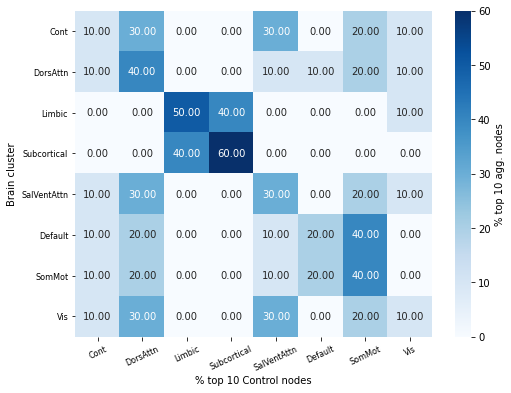

In [46]:
plt.figure(figsize=(8,6))
sns.heatmap(percent_array, annot=True, fmt=".2f", cmap="Blues",
           xticklabels=region_list, yticklabels=region_list, cbar_kws={'label': '% top 10 agg. nodes'})
plt.xticks(rotation=25, fontsize=8) 
plt.yticks(fontsize=8) 
plt.xlabel("% top 10 Control nodes")
plt.ylabel("Brain cluster")

plt.savefig(fpath+"target_controllability/"+"top10_agg_nodes.png", facecolor="white")

# Visualizing the target nodes, control nodes in Brain

In [13]:
# Region centers
# spatial coordinates of the 74 brain regions
df_coord = pd.read_csv(fpath+"roicenters2.txt", header=None)
df_coord = df_coord.rename(columns={0:"x", 1:"y", 2:"z"})
df_coord

,x,y,z
0,-25.7480,-32.6170,-17.3830
1,-20.8210,-78.7350,4.4348
2,-48.2900,-18.3100,12.3460
3,-54.5960,-8.2486,33.4490
4,-25.0360,-24.7570,61.2170
...,...,...,...
69,9.6888,-57.3140,42.3610
70,7.1268,-32.9430,66.7920
71,15.2080,10.4880,10.5160
72,25.4300,-59.5380,-24.9400


In [14]:
node_coord_dict = {}
for i in range(len(df_coord)):
    node_coord_dict[i+1] = df_coord.iloc[i,:].tolist()
    

In [10]:
def target_control_nodeInfo(region_name, centrality, agg_type):
    f = open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json')
 
    # returns JSON object as
    # a dictionary
    data = json.load(f)

    #print(data["region_name"])
    return data["target_nodes"], data["rank_agg"][agg_type]["agg_control_nodes"]

In [8]:
from nilearn import plotting

In [9]:

def plot_markers(node_values, node_coords, node_color, node_size='auto',
                 node_cmap=plt.cm.viridis_r, node_vmin=None, node_vmax=None, 
                 node_threshold=None, alpha=0.7, output_file=None,
                 display_mode="ortho", figure=None, axes=None, title=None,
                 annotate=True, black_bg=False, node_kwargs=None,
                 colorbar=True):
    """Plot network nodes (markers) on top of the brain glass schematics.
    Nodes are color coded according to provided nodal measure. Nodal measure
    usually represents some notion of node importance.
    Parameters
    ----------
    node_values : array_like of length n
        Vector containing nodal importance measure. Each node will be colored
        according to corresponding node value.
    node_coords : numpy array_like of shape (n, 3)
        3d coordinates of the graph nodes in world space.
    node_size : 'auto' or scalar or array-like, optional
        Size(s) of the nodes in points^2. By default the size of the node is
        inversely proportional to the number of nodes.
    node_cmap : str or colormap, optional
        Colormap used to represent the node measure. Default=plt.cm.viridis_r.
    node_vmin : float, optional
        Lower bound of the colormap. If `None`, the min of the node_values is
        used.
    node_vmax : float, optional
        Upper bound of the colormap. If `None`, the min of the node_values is
        used.
    node_threshold : float
        If provided only the nodes with a value greater than node_threshold
        will be shown.
    alpha : float between 0 and 1, optional
        Alpha transparency for markers. Default=0.7.
    %(output_file)s
    display_mode : string, optional
        Choose the direction of the cuts: 'x' - sagittal, 'y' - coronal,
        'z' - axial, 'l' - sagittal left hemisphere only,
        'r' - sagittal right hemisphere only, 'ortho' - three cuts are
        performed in orthogonal directions. Possible values are: 'ortho',
        'x', 'y', 'z', 'xz', 'yx', 'yz', 'l', 'r', 'lr', 'lzr', 'lyr',
        'lzry', 'lyrz'. Default='ortho'.
    %(figure)s
    %(axes)s
    %(title)s
    %(annotate)s
    %(black_bg)s
        Default=False.
    node_kwargs : dict, optional
        will be passed as kwargs to the plt.scatter call that plots all
        the nodes in one go
    %(colorbar)s
        Default=True.
    """
    node_values = np.squeeze(np.array(node_values))
    node_coords = np.array(node_coords)

    # Validate node_values
    if node_values.shape != (node_coords.shape[0], ):
        msg = ("Dimension mismatch: 'node_values' should be vector of length "
               "{0}, but current shape is {1} instead of {2}").format(
                   len(node_coords),
                   node_values.shape,
                   (node_coords.shape[0], ))
        raise ValueError(msg)

    display = plotting.plot_glass_brain(None, display_mode=display_mode,
                               figure=figure, axes=axes, title=title,
                               annotate=annotate, black_bg=black_bg)

    if isinstance(node_size, str) and node_size == 'auto':
        node_size = min(1e4 / len(node_coords), 100)

    # Filter out nodes with node values below threshold
    if node_threshold is not None:
        if node_threshold > np.max(node_values):
            msg = ("Provided 'node_threshold' value: {0} should not exceed "
                   "highest node value: {1}").format(node_threshold,
                                                     np.max(node_values))
            raise ValueError(msg)

        retained_nodes = node_values > node_threshold
        node_values = node_values[retained_nodes]
        node_coords = node_coords[retained_nodes]
        if isinstance(node_size, collections.abc.Iterable):
            node_size = [size for ok_retain, size in
                         zip(retained_nodes, node_size) if ok_retain]

    # Calculate node colors based on value
    #node_vmin = np.min(node_values) if node_vmin is None else node_vmin
    #node_vmax = np.max(node_values) if node_vmax is None else node_vmax
    #if node_vmin == node_vmax:
    #    node_vmin = 0.9 * node_vmin
    #    node_vmax = 1.1 * node_vmax
    #norm = matplotlib.colors.Normalize(vmin=node_vmin, vmax=node_vmax)
    #node_cmap = (plt.get_cmap(node_cmap) if isinstance(node_cmap, str)
    #             else node_cmap)
    #node_color = [node_cmap(norm(node_value)) for node_value in node_values]
    node_color=node_color
    # Prepare additional parameters for plt.scatter
    node_kwargs = {} if node_kwargs is None else node_kwargs
    node_kwargs.update([('alpha', alpha)])

    display.add_markers(
        marker_coords=node_coords,
        marker_color=node_color,
        marker_size=node_size,
        **node_kwargs
    )

    if colorbar:
        display._colorbar = True
        display._show_colorbar(cmap=node_cmap, norm=norm)

    if output_file is not None:
        display.savefig(output_file)
        display.close()
        display = None

    return display



In [122]:
import matplotlib

In [21]:
def target_control_nodeInfo(region_name, centrality, agg_type):
    f = open(fpath+"target_controllability/"+region_name+"_"+centrality+'.json')
 
    # returns JSON object as
    # a dictionary
    data = json.load(f)

    #print(data["region_name"])
    return data["target_nodes"], data["rank_agg"][agg_type]["agg_control_nodes"]

In [69]:
def plot_subcluster_controlNodes(node_coord_dict, region_name, centrality, agg_type):
    
    #agg_info(region_name, centrality, agg_type)
    tnodes, cnodes = target_control_nodeInfo(region_name, centrality, agg_type)

    print(tnodes)
    cmap = matplotlib.cm.get_cmap('tab10')

    blue = cmap(0)[:3]
    orange = cmap(1)[:3]
    node_color = [blue]*len(tnodes)+[orange]*len(cnodes)
    #green = cmap(2)[:3]
    #red = cmap(6)[:3]
    
    a1, a2 = 1, 0.2
    node_strength = [a1]*len(tnodes)+[a2]*len(cnodes)
    
    s1, s2 = 100, 250
    node_size = [s1]*len(tnodes)+[s2]*len(cnodes)
    
    #node_alpha = [a1]*len(tnodes)+[a2]*len(cnodes)
    
    node_coord_matrix = np.array([ node_coord_dict[i] for i in tnodes+cnodes  ])
    
    fig = plt.figure(figsize=(10,6))
    plt.plot([],[],'o',markersize=s1/17, alpha = a1,c=blue,label="Target nodes" )
    plt.plot([],[], "o",markersize=s2/17, alpha = a2+0.5, c=orange,label="Control nodes" )
    plt.legend(loc="upper left", prop={'size':10})
    plt.axis("off")

    plot_markers(node_values=node_strength, node_color=node_color,node_size=node_size, node_coords=node_coord_matrix, 
                 title=region_name, colorbar=False, figure=fig,  
                output_file=fpath+"target_controllability/"+region_name+"_"+centrality+"_"+agg_type+".png")#node_kwargs={"alpha":node_alpha})

    plt.show()
    
    

In [ ]:
plot_subcluster_controlNodes(node_coord_dict, "SomMot", "pq", "dowdall")

In [77]:
# 'Vis', 'pq', 'borda'
plot_subcluster_controlNodes(node_coord_dict,'Vis', 'pq', 'borda' )

[1, 2, 33, 34, 35]


# Visualize the location of brain clusters


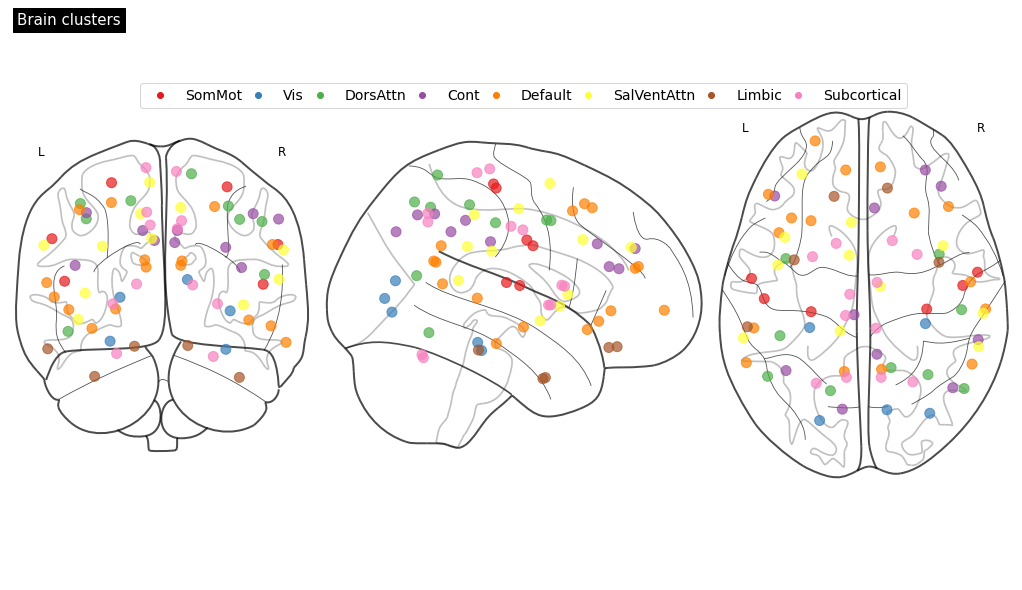

In [52]:


region_names = list(set(region_dict.values()))
cmap = matplotlib.cm.get_cmap('Set1')

node_color=[]
node_coord_matrix=[]
for i in range(len(region_names)):
    for key, value in region_dict.items():
        if value == region_names[i]:
            
            node_color.append( cmap(i)[:3] )
            node_coord_matrix.append( node_coord_dict[key] )
    
node_coord_matrix= np.array(node_coord_matrix)            
        

fig = plt.figure(figsize=(14,8))
n = len(region_names)

n_parcels = len(node_coord_matrix)

plt_dict = {}
for i in range(n):
    plt_dict[i] = plt.plot([],[],'o',c=cmap(i)[:3],label=region_names[i] )

plt.legend(loc="upper left", mode = "expand", ncol = n, prop={"size":14})
    
plt.axis("off")

plot_markers(node_values = np.ones(n_parcels)*0.7, node_color=node_color, node_coords=node_coord_matrix, 
             title="Brain clusters", colorbar=False, figure=fig)
plt.savefig(fpath+"target_controllability/"+"brain_clusters.png", facecolor="white")
plt.show()

# Visualize parcellation of brain

In [16]:
from nilearn import image

In [17]:
import nibabel as nib

networks100 = nib.load(fpath+"Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")

In [20]:
from nilearn import plotting
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(networks100, cmap=plotting.cm.bwr, figure=fig, output_file = "100parcels.png",
                  title='Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm')